# Raylegh Taylor instability with Free-Surface: The Drunken sailor effect

![Kaus2010_figure1.png](./Kaus2010_figure1.png)

Rayleigh–Taylor instability of a dense, more viscous layer ($\rho$ = 3300 kg/m3 , $\mu = 1e21$ Pa s), sinking through a less dense fluid ( = 3200 kg/m3 ,  = 1020 Pa s). Side boundaries
are free slip, the lower boundary is no-slip and the upper boundary is a free surface. The box is 500 × 500 km in size, and gravitational acceleration was 9.81 m/s2 . The initial
perturbation was sinusoidal with initial amplitude of 5 km. A constant time step of 2500 years (A) or 5000 years (B) was employed, with Q2 P−1 quadrilateral elements and
51 × 51 nodes. Whereas the 2500 years simulation evolves smoothly, the simulation with t = 5000 years results in a sloshing instability, in which the velocity pattern
changes direction from one time step to the other.

In [1]:
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis

loaded rc file /opt/venv/lib/python3.9/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

## Scaling

In [3]:
half_rate = 1.0 * u.centimeter / u.year
model_length = 500 * u.km
bodyforce = 3300 * u.kg / u.m**3 * 9.81 * u.m / u.s**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

## Model Geometry

In [4]:
gravity_vector = (0.0, -9.81 * u.m / u.s**2)

In [5]:
Model = GEO.Model(elementRes=(50, 64), 
                  elementType="Q2/dPc1",
                  minCoord=(-250. * u.km, -500. * u.km), 
                  maxCoord=(250. * u.km, 140. * u.km), 
                  gravity=gravity_vector)

	Global element size: 50x64
	Local offset of rank 0: 0x0
	Local range of rank 0: 50x64


In [6]:
Model.outputDir="op_Kaus2010_NoFreeSurface_Air_100ka"
#Model.outputDir="outputs_kaus2010_FreeSurface"

In [7]:
import underworld.function as fn

In [8]:
import numpy as np

amplitude = GEO.non_dimensionalise(5*u.km)
period = GEO.non_dimensionalise(Model.length) #* 2.0
interface_depth = GEO.non_dimensionalise(100*u.km)
func = -interface_depth + (amplitude * fn.math.cos(2.0*np.pi*fn.input()[0]/period))

shape = fn.input()[1] < -interface_depth + (amplitude * fn.math.cos(2.0*np.pi*fn.input()[0]/period))

In [9]:
Air_material = Model.add_material(name="Air_material", shape=GEO.shapes.Layer(top=Model.top, bottom=0.*u.km))
HD_material = Model.add_material(name="HD_material", shape=GEO.shapes.Layer(top=0.*u.km, bottom=Model.bottom))
LD_material = Model.add_material(name="LD_material", shape=shape)

In [10]:
npoints = 250
coords = np.ndarray((npoints, 2))
coords[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords[:, 1] = -interface_depth + (amplitude * np.cos(2.0*np.pi*coords[:, 0]/period))
#surf_tracers = Model.add_passive_tracers(name="Surface",vertices=coords)
Model.add_passive_tracers(name="Surface", vertices=coords)


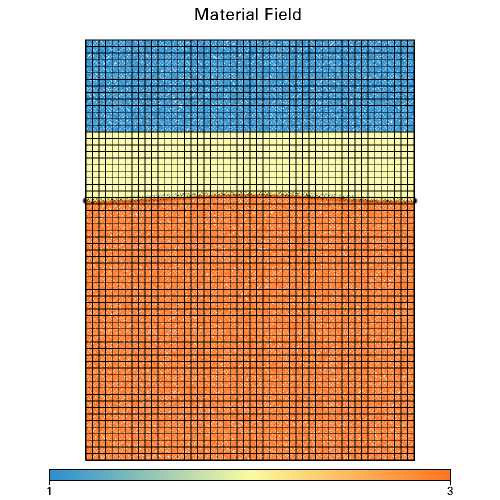

In [11]:
Fig = vis.Figure(figsize=(500,500), title="Material Field", quality=2)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.Mesh(Model.mesh)
Fig.Points(Model.Surface_tracers, pointSize=8.0)
Fig.show()

In [12]:
Air_material.density = 0. * u.kilogram / u.meter**3
LD_material.density = 3200 * u.kilogram / u.meter**3
HD_material.density = 3300 * u.kilogram / u.meter**3
Air_material.viscosity = 1e18 * u.pascal * u.second
LD_material.viscosity = 1e20 * u.pascal * u.second
HD_material.viscosity = 1e21 * u.pascal * u.second

## Boundary Conditions

In [13]:
Model.set_kinematicBCs(left=[0., None],
                       right=[0., None],
                       top=[None, None],
                       bottom=[None,0.],
                       order_wall_conditions=[ "top", "left", "right", "bottom"])

In [14]:
#Model.freeSurface = True

In [15]:
Model.fssa_factor = 1.0

# Compute initial condition

In [16]:
Model.init_model(pressure="lithostatic")

/opt/venv/lib/python3.9/site-packages/UWGeodynamics/_model.py:1566: UserWarning: Skipping the steady state calculation: No diffusivity variable defined on Model
  warnings.warn("Skipping the steady state calculation: No diffusivity variable defined on Model")



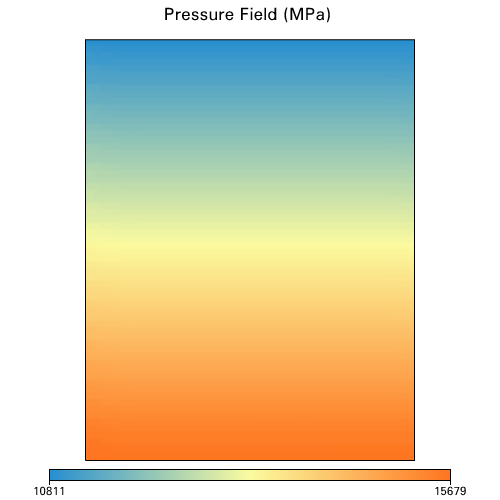

In [17]:
Fig = vis.Figure(figsize=(500,500), title="Pressure Field (MPa)", quality=3)
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.pressureField, u.megapascal))
Fig.show()


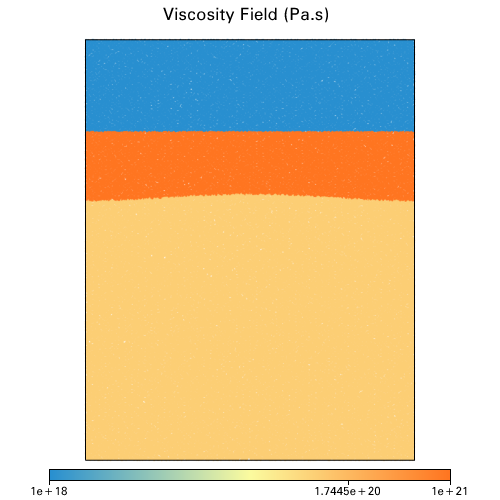

In [18]:
Fig = vis.Figure(figsize=(500,500), title="Viscosity Field (Pa.s)", quality=3)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.viscosityField, u.pascal * u.second),
           logScale=True,
           fn_size=3.0)
Fig.show()


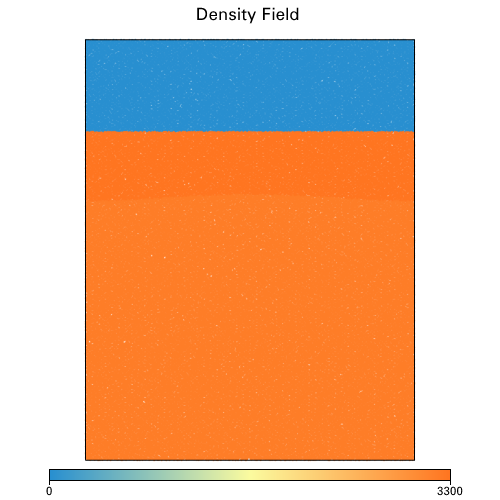

In [19]:
Fig = vis.Figure(figsize=(500,500), title="Density Field", quality=3)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.densityField, u.kg / u.m**3),
           fn_size=3.0)
Fig.show()

## Solver options

In [20]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-4

outputss=['pressureField',
         'strainRateField',
         'velocityField',
          'projTimeField',
           'projMaterialField',
         'projViscosityField',
         'projStressField',
         'projDensityField',
         'projStressTensor',]
GEO.rcParams['default.outputs']=outputss

In [21]:
Model.run_for(6.0 * u.megayears, checkpoint_interval=100000*u.year,dt=100000*u.year)
#Model.run_for(5.5 * u.megayears, checkpoint_interval=100000*u.year,dt=5000*u.year)

Running with UWGeodynamics version 2.12.1
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.030587 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01712 secs / 1 its
  Pressure Solve:         = 0.07 secs / 4 its
  Final V Solve:          = 0.01117 secs / 1 its

  Total BSSCR Linear solve time: 0.480843 seconds

Linear solver (SL1KDFVL__system-execute), solution time 4.961580e-01 (secs)
Time Integration
	2nd order:   

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1220 [min] /    0.1220 [max] (secs)
Time Integration - 0.122012 [min] / 0.122012 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000255976 [min] / 0.000255976 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:     7 Model Time: 400000.0 year dt: 35758.4 year (2022-02-09 04:29:27)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.023567 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01711 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1209 [min] /    0.1209 [max] (secs)
Time Integration - 0.120927 [min] / 0.120927 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000263714 [min] / 0.000263714 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:    14 Model Time: 1.1 megayear dt: 100000.0 year (2022-02-09 04:30:15)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.027326 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01737 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1143 [min] /    0.1143 [max] (secs)
Time Integration - 0.114315 [min] / 0.114315 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000244576 [min] / 0.000244576 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:    21 Model Time: 1.8 megayear dt: 100000.0 year (2022-02-09 04:31:04)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.024300 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01763 secs / 1 its
  Pressure Solve:   

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1149 [min] /    0.1149 [max] (secs)
Time Integration - 0.114882 [min] / 0.114882 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.0002531 [min] / 0.0002531 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:    28 Model Time: 2.4 megayear dt: 22410.0 year (2022-02-09 04:31:50)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.025879 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01771 secs / 1 its
  Pressure Solve:        

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1241 [min] /    0.1241 [max] (secs)
Time Integration - 0.124142 [min] / 0.124142 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000286714 [min] / 0.000286714 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:    35 Model Time: 2.8 megayear dt: 58401.1 year (2022-02-09 04:32:35)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.029558 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.03183 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1249 [min] /    0.1249 [max] (secs)
Time Integration - 0.124927 [min] / 0.124927 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000276874 [min] / 0.000276874 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:    42 Model Time: 3.1 megayear dt: 42379.3 year (2022-02-09 04:33:30)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.040115 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02323 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1327 [min] /    0.1327 [max] (secs)
Time Integration - 0.132687 [min] / 0.132687 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000278536 [min] / 0.000278536 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:    49 Model Time: 3.2 megayear dt: 9844.8 year (2022-02-09 04:34:25)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.025338 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01829 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1466 [min] /    0.1466 [max] (secs)
Time Integration - 0.146609 [min] / 0.146609 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000377399 [min] / 0.000377399 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:    56 Model Time: 3.4 megayear dt: 12462.5 year (2022-02-09 04:35:15)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.026446 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01848 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1277 [min] /    0.1277 [max] (secs)
Time Integration - 0.127704 [min] / 0.127704 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.00049443 [min] / 0.00049443 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:    63 Model Time: 3.5 megayear dt: 23864.7 year (2022-02-09 04:35:55)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.026490 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02303 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1319 [min] /    0.1319 [max] (secs)
Time Integration - 0.131927 [min] / 0.131927 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000467269 [min] / 0.000467269 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:    70 Model Time: 3.7 megayear dt: 9762.8 year (2022-02-09 04:36:45)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.028040 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02227 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1266 [min] /    0.1266 [max] (secs)
Time Integration - 0.126666 [min] / 0.126666 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000291789 [min] / 0.000291789 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:    77 Model Time: 3.7 megayear dt: 7153.5 year (2022-02-09 04:37:29)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.026221 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01801 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1226 [min] /    0.1226 [max] (secs)
Time Integration - 0.122663 [min] / 0.122663 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.0002815 [min] / 0.0002815 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:    84 Model Time: 3.8 megayear dt: 9574.5 year (2022-02-09 04:38:12)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.026092 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01844 secs / 1 its
  Pressure Solve:         

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1196 [min] /    0.1196 [max] (secs)
Time Integration - 0.119607 [min] / 0.119607 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0002 [min] /    0.0002 [max] (secs)
Time Integration - 0.000277092 [min] / 0.000277092 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:    91 Model Time: 3.9 megayear dt: 6681.2 year (2022-02-09 04:38:54)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.026169 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0188 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1201 [min] /    0.1201 [max] (secs)
Time Integration - 0.120118 [min] / 0.120118 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000474683 [min] / 0.000474683 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:    98 Model Time: 3.9 megayear dt: 6385.2 year (2022-02-09 04:39:51)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.033153 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02226 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1634 [min] /    0.1634 [max] (secs)
Time Integration - 0.163426 [min] / 0.163426 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000466441 [min] / 0.000466441 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   105 Model Time: 4.0 megayear dt: 5853.0 year (2022-02-09 04:40:54)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.033629 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.03813 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1426 [min] /    0.1426 [max] (secs)
Time Integration - 0.142694 [min] / 0.142694 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0007 [min] /    0.0007 [max] (secs)
Time Integration - 0.000834112 [min] / 0.000834112 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   112 Model Time: 4.0 megayear dt: 7901.8 year (2022-02-09 04:41:57)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.028317 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.03358 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1436 [min] /    0.1436 [max] (secs)
Time Integration - 0.143668 [min] / 0.143668 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000652196 [min] / 0.000652196 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   119 Model Time: 4.1 megayear dt: 6144.3 year (2022-02-09 04:42:48)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.032677 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.03122 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1585 [min] /    0.1585 [max] (secs)
Time Integration - 0.158496 [min] / 0.158496 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000343759 [min] / 0.000343759 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   126 Model Time: 4.1 megayear dt: 6723.2 year (2022-02-09 04:43:49)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.041387 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01828 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1287 [min] /    0.1287 [max] (secs)
Time Integration - 0.128741 [min] / 0.128741 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000486854 [min] / 0.000486854 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   133 Model Time: 4.1 megayear dt: 5931.0 year (2022-02-09 04:44:41)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.023965 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01832 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.2742 [min] /    0.2742 [max] (secs)
Time Integration - 0.274286 [min] / 0.274286 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000539766 [min] / 0.000539766 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   140 Model Time: 4.2 megayear dt: 4684.0 year (2022-02-09 04:45:48)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.028416 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.03151 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1722 [min] /    0.1722 [max] (secs)
Time Integration - 0.172212 [min] / 0.172212 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000545458 [min] / 0.000545458 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   147 Model Time: 4.2 megayear dt: 5286.2 year (2022-02-09 04:46:46)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.035206 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01924 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1341 [min] /    0.1341 [max] (secs)
Time Integration - 0.134132 [min] / 0.134132 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000352088 [min] / 0.000352088 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   154 Model Time: 4.2 megayear dt: 4731.3 year (2022-02-09 04:47:41)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.025341 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01966 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1211 [min] /    0.1211 [max] (secs)
Time Integration - 0.121128 [min] / 0.121128 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000374858 [min] / 0.000374858 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   161 Model Time: 4.3 megayear dt: 4417.0 year (2022-02-09 04:48:37)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.025883 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.02199 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1338 [min] /    0.1338 [max] (secs)
Time Integration - 0.133853 [min] / 0.133853 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000302171 [min] / 0.000302171 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   168 Model Time: 4.4 megayear dt: 10690.9 year (2022-02-09 04:49:27)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.026332 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01847 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.2130 [min] /    0.2130 [max] (secs)
Time Integration - 0.213082 [min] / 0.213082 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000308718 [min] / 0.000308718 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   175 Model Time: 4.4 megayear dt: 4280.2 year (2022-02-09 04:50:26)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.028075 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01918 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1407 [min] /    0.1407 [max] (secs)
Time Integration - 0.140756 [min] / 0.140756 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000304511 [min] / 0.000304511 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   182 Model Time: 4.4 megayear dt: 4390.0 year (2022-02-09 04:51:26)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.025498 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01836 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1293 [min] /    0.1293 [max] (secs)
Time Integration - 0.12929 [min] / 0.12929 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000438209 [min] / 0.000438209 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   189 Model Time: 4.5 megayear dt: 4430.3 year (2022-02-09 04:52:15)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.026512 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01837 secs / 1 its
  Pressure Solve:       

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1216 [min] /    0.1216 [max] (secs)
Time Integration - 0.121596 [min] / 0.121596 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.00034617 [min] / 0.00034617 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   196 Model Time: 4.5 megayear dt: 5891.3 year (2022-02-09 04:53:06)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.024861 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01784 secs / 1 its
  Pressure Solve:       

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1212 [min] /    0.1212 [max] (secs)
Time Integration - 0.121191 [min] / 0.121191 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000284779 [min] / 0.000284779 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   203 Model Time: 4.5 megayear dt: 4265.2 year (2022-02-09 04:53:56)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.024712 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01773 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1209 [min] /    0.1209 [max] (secs)
Time Integration - 0.120943 [min] / 0.120943 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000305148 [min] / 0.000305148 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   210 Model Time: 4.6 megayear dt: 8689.1 year (2022-02-09 04:54:47)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.026241 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01824 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1272 [min] /    0.1272 [max] (secs)
Time Integration - 0.127184 [min] / 0.127184 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000360034 [min] / 0.000360034 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   217 Model Time: 4.6 megayear dt: 7786.5 year (2022-02-09 04:55:40)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.025668 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01787 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1214 [min] /    0.1214 [max] (secs)
Time Integration - 0.121464 [min] / 0.121464 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000497151 [min] / 0.000497151 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   224 Model Time: 4.7 megayear dt: 5574.8 year (2022-02-09 04:56:32)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.026294 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0181 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1202 [min] /    0.1202 [max] (secs)
Time Integration - 0.120249 [min] / 0.120249 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.00032157 [min] / 0.00032157 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   231 Model Time: 4.7 megayear dt: 7909.1 year (2022-02-09 04:57:26)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.024813 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01794 secs / 1 its
  Pressure Solve:       

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1213 [min] /    0.1213 [max] (secs)
Time Integration - 0.121308 [min] / 0.121308 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000293398 [min] / 0.000293398 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   238 Model Time: 4.8 megayear dt: 6823.1 year (2022-02-09 04:58:19)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.025881 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01805 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1211 [min] /    0.1211 [max] (secs)
Time Integration - 0.121151 [min] / 0.121151 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000292226 [min] / 0.000292226 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   245 Model Time: 4.8 megayear dt: 10519.2 year (2022-02-09 04:59:14)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.025892 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01809 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1284 [min] /    0.1284 [max] (secs)
Time Integration - 0.128414 [min] / 0.128414 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000307539 [min] / 0.000307539 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   252 Model Time: 4.9 megayear dt: 6957.5 year (2022-02-09 05:00:07)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.024230 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01769 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1304 [min] /    0.1304 [max] (secs)
Time Integration - 0.130482 [min] / 0.130482 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000329206 [min] / 0.000329206 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   259 Model Time: 4.9 megayear dt: 6171.7 year (2022-02-09 05:01:03)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.024109 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01807 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1207 [min] /    0.1207 [max] (secs)
Time Integration - 0.120764 [min] / 0.120764 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.0003086 [min] / 0.0003086 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   266 Model Time: 5.0 megayear dt: 7054.7 year (2022-02-09 05:01:58)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.025729 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01794 secs / 1 its
  Pressure Solve:         

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1287 [min] /    0.1287 [max] (secs)
Time Integration - 0.128708 [min] / 0.128708 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000325934 [min] / 0.000325934 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   273 Model Time: 5.0 megayear dt: 6491.3 year (2022-02-09 05:02:55)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.024800 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01753 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1303 [min] /    0.1303 [max] (secs)
Time Integration - 0.130362 [min] / 0.130362 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000515702 [min] / 0.000515702 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   280 Model Time: 5.1 megayear dt: 6295.4 year (2022-02-09 05:03:51)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.025910 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01801 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1283 [min] /    0.1283 [max] (secs)
Time Integration - 0.128344 [min] / 0.128344 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000318914 [min] / 0.000318914 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   287 Model Time: 5.1 megayear dt: 8142.1 year (2022-02-09 05:04:49)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.025585 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01811 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1284 [min] /    0.1284 [max] (secs)
Time Integration - 0.128405 [min] / 0.128405 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0005 [min] /    0.0005 [max] (secs)
Time Integration - 0.000532203 [min] / 0.000532203 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   294 Model Time: 5.2 megayear dt: 6348.7 year (2022-02-09 05:05:46)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.025612 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01792 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1308 [min] /    0.1308 [max] (secs)
Time Integration - 0.130816 [min] / 0.130816 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000318979 [min] / 0.000318979 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   301 Model Time: 5.2 megayear dt: 4878.1 year (2022-02-09 05:06:46)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.023597 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01791 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1218 [min] /    0.1218 [max] (secs)
Time Integration - 0.121853 [min] / 0.121853 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000297201 [min] / 0.000297201 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   308 Model Time: 5.2 megayear dt: 6406.4 year (2022-02-09 05:07:43)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.024305 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01744 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1214 [min] /    0.1214 [max] (secs)
Time Integration - 0.121475 [min] / 0.121475 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000481478 [min] / 0.000481478 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   315 Model Time: 5.3 megayear dt: 7396.6 year (2022-02-09 05:08:41)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.023890 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01772 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1289 [min] /    0.1289 [max] (secs)
Time Integration - 0.128954 [min] / 0.128954 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.00033196 [min] / 0.00033196 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   322 Model Time: 5.3 megayear dt: 7369.7 year (2022-02-09 05:09:41)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.026121 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01794 secs / 1 its
  Pressure Solve:       

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1318 [min] /    0.1318 [max] (secs)
Time Integration - 0.131849 [min] / 0.131849 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.00032817 [min] / 0.00032817 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   329 Model Time: 5.4 megayear dt: 6687.2 year (2022-02-09 05:10:42)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.024203 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01761 secs / 1 its
  Pressure Solve:       

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1301 [min] /    0.1301 [max] (secs)
Time Integration - 0.130164 [min] / 0.130164 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000332867 [min] / 0.000332867 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   336 Model Time: 5.4 megayear dt: 8005.1 year (2022-02-09 05:11:43)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.024825 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01772 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1231 [min] /    0.1231 [max] (secs)
Time Integration - 0.123116 [min] / 0.123116 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000322512 [min] / 0.000322512 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   343 Model Time: 5.5 megayear dt: 8161.7 year (2022-02-09 05:12:44)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.025732 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.0178 secs / 1 its
  Pressure Solve:      

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1221 [min] /    0.1221 [max] (secs)
Time Integration - 0.122111 [min] / 0.122111 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000321644 [min] / 0.000321644 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   350 Model Time: 5.5 megayear dt: 8061.6 year (2022-02-09 05:13:47)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.024506 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01767 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1221 [min] /    0.1221 [max] (secs)
Time Integration - 0.122123 [min] / 0.122123 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000319652 [min] / 0.000319652 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   357 Model Time: 5.6 megayear dt: 2914.4 year (2022-02-09 05:14:51)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.024288 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01753 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1252 [min] /    0.1252 [max] (secs)
Time Integration - 0.12521 [min] / 0.12521 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000401026 [min] / 0.000401026 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   364 Model Time: 5.7 megayear dt: 9403.6 year (2022-02-09 05:15:53)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.025807 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01789 secs / 1 its
  Pressure Solve:       

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1316 [min] /    0.1316 [max] (secs)
Time Integration - 0.131584 [min] / 0.131584 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0004 [min] /    0.0004 [max] (secs)
Time Integration - 0.000447129 [min] / 0.000447129 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   371 Model Time: 5.7 megayear dt: 11284.9 year (2022-02-09 05:16:58)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.025379 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01789 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1231 [min] /    0.1231 [max] (secs)
Time Integration - 0.123147 [min] / 0.123147 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000315238 [min] / 0.000315238 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   378 Model Time: 5.8 megayear dt: 13037.3 year (2022-02-09 05:18:04)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.024538 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01749 secs / 1 its
  Pressure Solve:    

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1307 [min] /    0.1307 [max] (secs)
Time Integration - 0.130762 [min] / 0.130762 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000375949 [min] / 0.000375949 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   385 Model Time: 5.9 megayear dt: 5174.2 year (2022-02-09 05:19:10)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.025658 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01779 secs / 1 its
  Pressure Solve:     

Time Integration
	2nd order:                 0LJI2C4W__integrand -    0.1249 [min] /    0.1249 [max] (secs)
Time Integration - 0.12494 [min] / 0.12494 [max] (secs)
Time Integration
	2nd order:                 G6U6YMG7__integrand -    0.0003 [min] /    0.0003 [max] (secs)
Time Integration - 0.000335156 [min] / 0.000335156 [max] (secs)
In func WeightsCalculator_CalculateAll(): for swarm "51YZ9M3Z__swarm"
	done 33% (1067 cells)...
	done 67% (2134 cells)...
	done 100% (3200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "51YZ9M3Z__swarm"
Step:   392 Model Time: 6.0 megayear dt: 13935.5 year (2022-02-09 05:20:15)
Linear solver (SL1KDFVL__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 


-----  K2_GMG  ------

AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 1000000.000000


	* K+p*K2 in time: 0.023943 seconds

  Setting schur_pc to "gkgdiag" 


SCR Solver Summary:

  RHS V Solve:            = 0.01776 secs / 1 its
  Pressure Solve:      

1

In [22]:
#Model.run_for(nstep=55, checkpoint_interval=1, dt=100000*u.year)
#Model.run_for(nstep=1100, checkpoint_interval=1, dt=5000*u.year)


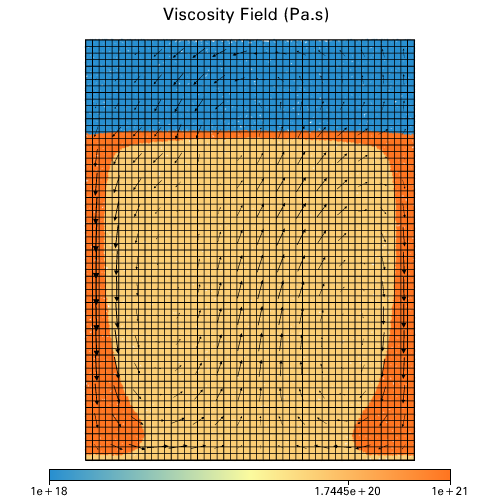

In [23]:
Fig = vis.Figure(figsize=(500,500), title="Viscosity Field (Pa.s)", quality=3)
Fig.Mesh(Model.mesh)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.viscosityField, u.pascal * u.second),
           logScale=True,
           fn_size=3.0)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()